# A Hybrid Recommender System for Mobile App Stores: Tackling Sparsity in User Ratings

---

This notebook implements a hybrid recommender system that combines collaborative filtering with content-based filtering to enhance recommendation accuracy for users with limited historical interactions in mobile app stores.


## Objective
The goal of this project is to develop a recommender system for mobile apps, addressing the sparsity challenge inherent in user-item rating matrices. By combining collaborative filtering with content-based filtering, the aim is to enhance recommendation accuracy for users with limited historical interactions.

## Setup & Dependencies

**Prerequisites**: Make sure you have installed all required packages by running:
```bash
pip install -r requirements.txt
```

The following cells will set up the environment and load necessary libraries.

In [ ]:
# Setup for local environment
import os
from huggingface_hub import login

# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Environment setup complete!")
print("\nNote: You may need to authenticate with Hugging Face to access the dataset.")
print("If the dataset loading fails, run the next cell to login.")

Environment setup complete!

Note: You may need to authenticate with Hugging Face to access the dataset.
If the dataset loading fails, run the next cell to login.


In [ ]:
# os.environ["HF_TOKEN"] = "Replace with your own token"


## Load Core Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import random
import pickle
import joblib
import warnings
from itertools import product
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset, Reader, accuracy
from surprise import NormalPredictor, BaselineOnly, KNNBaseline, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from tqdm import tqdm

warnings.filterwarnings('ignore')
random.seed(123)
np.random.seed(123)

## Load and Sample 3,000 Users from a 19.3 Million-Row Interaction Dataset on Hugging Face + Data Preprocessing

In [26]:
user_ids = set()

try:
    streaming_data = load_dataset(
        'recmeapp/mobilerec',
        data_files='interactions/mobilerec_final.csv',
        split='train',
        streaming=True
    )
    print("✓ Dataset loaded successfully!")
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    print("\nTo fix this:")
    print("1. Go back to the authentication cell above")
    print("2. Uncomment the login() line")
    print("3. Run that cell and enter your Hugging Face token")
    print("4. Then re-run this cell")
    print("5. Get your token from: https://huggingface.co/settings/tokens")
    raise

for row in tqdm(streaming_data, total=19_300_000):
    uid = row.get('uid')
    if uid:
        user_ids.add(uid)
    if len(user_ids) >= 30_000:
        break

sampled_users = set(random.sample(sorted(user_ids), 3000))

rows = []
try:
    streaming_data = load_dataset(
        'recmeapp/mobilerec',
        data_files='interactions/mobilerec_final.csv',
        split='train',
        streaming=True
    )
except Exception as e:
    print(f"✗ Error loading dataset for interactions: {e}")
    print("Make sure you've authenticated with Hugging Face (see instructions above)")
    raise

for row in tqdm(streaming_data, total=19_300_000):
    if row.get('uid') in sampled_users:
        rows.append({
            'uid': row.get('uid'),
            'app_package': row.get('app_package'),
            'rating': row.get('rating', 1),
            'date': row.get('date'),
            'app_category': row.get('app_category', 'Unknown')
        })

if rows:
    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df = df.sort_values(by=["uid", "date"])
    print(f"Loaded {len(df):,} rows for 3,000 users.")
else:
    print("No rows were matched. Check if sampled_users is empty or mismatched.")


✓ Dataset loaded successfully!


100%|█████████▉| 19297019/19300000 [05:09<00:00, 62409.24it/s]

Loaded 19,475 rows for 3,000 users.


In [27]:
# Loaded dataset contains at least 5 interactions per user
df.uid.value_counts().sort_values(ascending=False)

uid
NqhTSgQq5RyzlrFA    25
OtyCrcFKUhiRCRdw    23
mElk8Wh1bcWXwlWo    19
GEiCLNtznzoMosD9    18
3Mdnpdne4njknJ62    18
                    ..
89AQTtUGQjS1cVFy     5
2kuBGrfE5dH6OUMK     5
2mnqtSovTqHzN9Jh     5
rpDHAUOhU0EEKpnP     5
zyFBTxTPCSbXv7UV     5
Name: count, Length: 3000, dtype: int64

In [28]:
# Count the number of unique applications in the dataset
df.app_package.nunique()

5165

In [29]:
df.isnull().sum()

uid             0
app_package     0
rating          0
date            0
app_category    0
dtype: int64

In [30]:
print("Loading app metadata...")
try:
    meta_data = load_dataset(
        'recmeapp/mobilerec',
        data_files='app_meta/app_meta.csv',
        split='train'
    )
    app_meta_df = pd.DataFrame(meta_data)
    print("✓ App metadata loaded successfully!")
    print(app_meta_df.head())
except Exception as e:
    print(f"✗ Error loading app metadata: {e}")
    print("Make sure you've authenticated with Hugging Face (see authentication cell above)")
    raise


Loading app metadata...
✓ App metadata loaded successfully!
                    app_package  \
0            com.natewren.lines   
1  com.capitalone.credittracker   
2        com.purascents.android   
3        com.wallethub.mywallet   
4        air.com.samuramu.gg.se   

                                            app_name  \
0                              Lines Pro - Icon Pack   
1                        CreditWise from Capital One   
2                   Pura - Smart Fragrance Dispenser   
3  WalletHub - Free Credit Score, Report & Monito...   
4            #SelfLove (GG Confidence & Self esteem)   

              developer_name     app_category  \
0           Nate Wren Design  Personalization   
1  Capital One Services, LLC          Finance   
2                       Pura     House & Home   
3                  WalletHub          Finance   
4                 Ggtude Ltd          Medical   

                                         description content_rating  \
0  Lines icons (pro versio

In [31]:
app_meta_df.head()

,app_package,app_name,developer_name,app_category,description,content_rating,num_reviews,price,avg_rating
0,com.natewren.lines,Lines Pro - Icon Pack,Nate Wren Design,Personalization,Lines icons (pro version) are outlined shapes ...,Everyone,"2,997",$1.99 Buy,4.7
1,com.capitalone.credittracker,CreditWise from Capital One,"Capital One Services, LLC",Finance,Know your credit score and much more\n\nCapita...,Everyone,"94,914",Install,4.7
2,com.purascents.android,Pura - Smart Fragrance Dispenser,Pura,House & Home,Pura is a smart home fragrance device that you...,Everyone,778,Install,4.4
3,com.wallethub.mywallet,"WalletHub - Free Credit Score, Report & Monito...",WalletHub,Finance,WalletHub is the first app to offer 100% free ...,Everyone,"7,025",Install,4.7
4,air.com.samuramu.gg.se,#SelfLove (GG Confidence & Self esteem),Ggtude Ltd,Medical,Wish to build confidence and have higher self ...,Everyone,625,Install,4.1


In [32]:
len(app_meta_df)

10173

In [33]:
app_meta_df.head(10)

,app_package,app_name,developer_name,app_category,description,content_rating,num_reviews,price,avg_rating
0,com.natewren.lines,Lines Pro - Icon Pack,Nate Wren Design,Personalization,Lines icons (pro version) are outlined shapes ...,Everyone,"2,997",$1.99 Buy,4.7
1,com.capitalone.credittracker,CreditWise from Capital One,"Capital One Services, LLC",Finance,Know your credit score and much more\n\nCapita...,Everyone,"94,914",Install,4.7
2,com.purascents.android,Pura - Smart Fragrance Dispenser,Pura,House & Home,Pura is a smart home fragrance device that you...,Everyone,778,Install,4.4
3,com.wallethub.mywallet,"WalletHub - Free Credit Score, Report & Monito...",WalletHub,Finance,WalletHub is the first app to offer 100% free ...,Everyone,"7,025",Install,4.7
4,air.com.samuramu.gg.se,#SelfLove (GG Confidence & Self esteem),Ggtude Ltd,Medical,Wish to build confidence and have higher self ...,Everyone,625,Install,4.1
5,com.booster.gfx,Game Booster : Launcher - GFX,TOLAN,Libraries & Demo,Game Booster will unlock your device's maximum...,Everyone,"16,877",Install,4.5
6,com.nbcuni.nbc,The NBC App - Stream TV Shows,"NBCUniversal Media, LLC",Entertainment,Stream TV and watch episodes of current NBC TV...,Teen,"124,483",Install,3.9
7,com.dreame.writer,Stary Writing-To Be A Stary Exclusive Writer,Dreame Media,Books & Reference,Follow your passion for writing Now! You can b...,Teen,"2,360",Install,3.3
8,com.activision.callofduty.shooter,Call of Duty Mobile Season 2,"Activision Publishing, Inc.",Action,"""The CALL OF DUTY® you know and love now on yo...",Mature 17+,"14,777,260",Install,4.3
9,com.criterionchannel,The Criterion Channel,The Criterion Collection,Entertainment,"A movie lover’s dream, the Criterion Channel o...",Teen,"3,360",Install,4.6


In [34]:
# Define which static columns to keep from app_meta_df: Everything except num_reviews and avg_rating, which are cumulative
meta_static_cols = [
    "app_package", "app_name", "developer_name", "app_category",
    "description", "content_rating", "price"
]

# Merge with df
df_merged = df.merge(app_meta_df[meta_static_cols], on="app_package", how="left")

In [35]:
df_merged.shape

(19475, 11)

In [36]:
df_merged.head()

,uid,app_package,rating,date,app_category_x,app_name,developer_name,app_category_y,description,content_rating,price
0,00KTAxXg0Ok6u2pH,com.kamagames.roulettist,4,2014-01-23,Casino,Casino Roulette: Roulettist,KamaGames,Casino,Play the best free roulette game with millions...,Teen,Install
1,00KTAxXg0Ok6u2pH,com.amadeus.cmt.client.android,4,2017-01-08,Travel & Local,CheckMyTrip,Amadeus IT Group SA,Travel & Local,CheckMyTrip is your complete travel itinerary ...,Everyone,Install
2,00KTAxXg0Ok6u2pH,com.diggitaldogg.rapempire,5,2021-02-25,Simulation,Snoop Dogg's Rap Empire,diGGital doGG,Simulation,Are you ready to become a rap legend? Start yo...,Everyone,Install
3,00KTAxXg0Ok6u2pH,com.citybay.farming.citybuilding,2,2021-03-22,Casual,Farm City: Farming & City Building,Zego Studio,Casual,Farm City: City building & Farming is one of t...,Everyone,Install
4,00KTAxXg0Ok6u2pH,com.disney.datg.videoplatforms.android.abcf,5,2021-04-14,Entertainment,Freeform - Movies & TV Shows,Disney,Entertainment,Watch full episodes of Freeform shows like Cru...,Everyone,Install


In [37]:
mismatch_count = (df_merged["app_category_x"] != df_merged["app_category_y"]).sum()
print(f"Number of mismatches between app_category_x and app_category_y: {mismatch_count}")

Number of mismatches between app_category_x and app_category_y: 0


In [38]:
df_merged.drop(columns=["app_category_y"], inplace=True)
df_merged.rename(columns={"app_category_x": "app_category"}, inplace=True)

In [39]:
# df_merged is the final dataset containing all interactions before the train/val/test split
df_merged

,uid,app_package,rating,date,app_category,app_name,developer_name,description,content_rating,price
0,00KTAxXg0Ok6u2pH,com.kamagames.roulettist,4,2014-01-23,Casino,Casino Roulette: Roulettist,KamaGames,Play the best free roulette game with millions...,Teen,Install
1,00KTAxXg0Ok6u2pH,com.amadeus.cmt.client.android,4,2017-01-08,Travel & Local,CheckMyTrip,Amadeus IT Group SA,CheckMyTrip is your complete travel itinerary ...,Everyone,Install
2,00KTAxXg0Ok6u2pH,com.diggitaldogg.rapempire,5,2021-02-25,Simulation,Snoop Dogg's Rap Empire,diGGital doGG,Are you ready to become a rap legend? Start yo...,Everyone,Install
3,00KTAxXg0Ok6u2pH,com.citybay.farming.citybuilding,2,2021-03-22,Casual,Farm City: Farming & City Building,Zego Studio,Farm City: City building & Farming is one of t...,Everyone,Install
4,00KTAxXg0Ok6u2pH,com.disney.datg.videoplatforms.android.abcf,5,2021-04-14,Entertainment,Freeform - Movies & TV Shows,Disney,Watch full episodes of Freeform shows like Cru...,Everyone,Install
...,...,...,...,...,...,...,...,...,...,...
19470,zyFBTxTPCSbXv7UV,com.betterment,2,2017-07-07,Finance,Betterment: Investing & Saving,Betterment,Invest better with Betterment. Investing apps ...,Everyone,Install
19471,zyFBTxTPCSbXv7UV,com.etermax.trivia.preguntados2,4,2020-01-02,Trivia,Trivia Crack 2,etermax,"🧠 Sharpen your mind with Trivia Crack 2, the b...",Everyone,Install
19472,zyFBTxTPCSbXv7UV,ly.omegle.android,3,2021-07-15,Social,Omega - Live Random Video Chat,Omega Tech.,"Omega, a free random video chat and live talk ...",Mature 17+,Install
19473,zyFBTxTPCSbXv7UV,com.raongames.growcastle,5,2022-03-22,Arcade,Grow Castle - Tower Defense,RAON GAMES,It is a defense game to protect the castle fro...,Teen,Install


Sparsity refers to how many entries are missing in the user–item interaction matrix. In this case, a high sparsity value reflects a real-world scenario, where it's common to have limited observed interactions. This highlights one of the key challenges in building a recommender system: learning meaningful patterns from limited user history.


In [57]:
num_users = df_merged['uid'].nunique()
num_items = df_merged['app_package'].nunique()
observed = len(df_merged)
sparsity = 1 - (observed / (num_users * num_items))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 99.87%


To simulate a realistic recommendation scenario, I split each user's interaction history chronologically.
The most recent interaction is held out for testing, and the second most recent for validation — the rest is used for training.

This setup reflects how recommender systems operate in practice: models are trained on a user’s past behavior and evaluated on their ability to predict future interactions.
By using just one validation and one test point per user, I ensure the evaluation remains fair and consistent, even for users with limited history.


In [58]:
def split_user_interactions(user_df, n_val=1, n_test=1):
    user_df = user_df.sort_values("date")
    train = user_df.iloc[:-n_val-n_test]
    val   = user_df.iloc[-n_val-n_test:-n_test]
    test  = user_df.iloc[-n_test:]
    return train, val, test

n_val, n_test = 1, 1
train_parts, val_parts, test_parts = [], [], []

for uid, user_df in df_merged.groupby("uid"):
    if len(user_df) < n_val + n_test + 1:
        continue
    t, v, te = split_user_interactions(user_df, n_val=n_val, n_test=n_test)
    train_parts.append(t)
    val_parts.append(v)
    test_parts.append(te)

train_df = pd.concat(train_parts).reset_index(drop=True)
val_df   = pd.concat(val_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)



# 6. Optional: print summary
print(f"✅ Train: {len(train_df):,} rows")
print(f"✅ Val:   {len(val_df):,} rows")
print(f"✅ Test:  {len(test_df):,} rows")

✅ Train: 13,475 rows
✅ Val:   3,000 rows
✅ Test:  3,000 rows


## Assumptions

- Users’ past interactions are predictive of their future preferences.
- The sampled subset of users (3,000) is sufficiently representative to prototype and evaluate recommendation strategies, even though the full dataset is much larger.
- App metadata (title, description, category) provides enough meaningful information for effective content-based recommendations.
- The hybrid approach helps mitigate sparsity and cold-start effects for users with limited interaction histories and for new or infrequently rated apps.
- This system does not address extreme cold-start cases where users have zero historical interactions, which would require additional user-side features beyond ratings.


## EDA

In [59]:
train_df

,uid,app_package,rating,date,app_category,app_name,developer_name,description,content_rating,price
0,00KTAxXg0Ok6u2pH,com.kamagames.roulettist,4,2014-01-23,Casino,Casino Roulette: Roulettist,KamaGames,Play the best free roulette game with millions...,Teen,Install
1,00KTAxXg0Ok6u2pH,com.amadeus.cmt.client.android,4,2017-01-08,Travel & Local,CheckMyTrip,Amadeus IT Group SA,CheckMyTrip is your complete travel itinerary ...,Everyone,Install
2,00KTAxXg0Ok6u2pH,com.diggitaldogg.rapempire,5,2021-02-25,Simulation,Snoop Dogg's Rap Empire,diGGital doGG,Are you ready to become a rap legend? Start yo...,Everyone,Install
3,00KTAxXg0Ok6u2pH,com.citybay.farming.citybuilding,2,2021-03-22,Casual,Farm City: Farming & City Building,Zego Studio,Farm City: City building & Farming is one of t...,Everyone,Install
4,00KTAxXg0Ok6u2pH,com.disney.datg.videoplatforms.android.abcf,5,2021-04-14,Entertainment,Freeform - Movies & TV Shows,Disney,Watch full episodes of Freeform shows like Cru...,Everyone,Install
...,...,...,...,...,...,...,...,...,...,...
13470,zxwV9wJdzJzRdWSL,com.wemesh.android,5,2021-09-21,Entertainment,Rave – Watch Party,Rave Inc.,"Watch the latest from Netflix, the most popula...",Teen,Install
13471,zxwV9wJdzJzRdWSL,com.volcanoforce.lost.global,3,2021-11-12,Adventure,LOST in Blue (Global),Volcano Force,"After surviving a plane crash, you must collec...",Mature 17+,Install
13472,zyFBTxTPCSbXv7UV,com.betterment,2,2017-07-07,Finance,Betterment: Investing & Saving,Betterment,Invest better with Betterment. Investing apps ...,Everyone,Install
13473,zyFBTxTPCSbXv7UV,com.etermax.trivia.preguntados2,4,2020-01-02,Trivia,Trivia Crack 2,etermax,"🧠 Sharpen your mind with Trivia Crack 2, the b...",Everyone,Install


In [60]:
train_df.isnull().sum()

uid               0
app_package       0
rating            0
date              0
app_category      0
app_name          0
developer_name    0
description       0
content_rating    0
price             0
dtype: int64

In [61]:
np.dtype(train_df['uid']), np.dtype(train_df['app_package']), np.dtype(train_df['rating'])

(dtype('O'), dtype('O'), dtype('int64'))

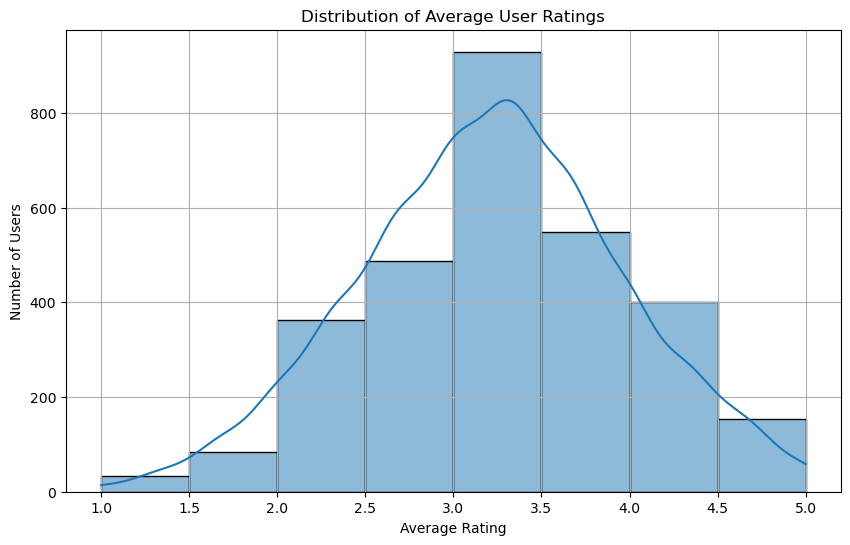

In [62]:
# Group by uid and calculate the average rating
avg_rating_per_user = train_df.groupby('uid')['rating'].mean().reset_index()
avg_rating_per_user.columns = ['uid', 'avg_rating']

# Plot the distribution of the average ratings
plt.figure(figsize=(10, 6))
sns.histplot(avg_rating_per_user['avg_rating'], bins=8, kde=True)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

In [63]:
train_df.app_category.value_counts().sort_values(ascending=False)

app_category
Action                     966
Role Playing               957
Simulation                 758
Strategy                   750
Casual                     619
Puzzle                     605
Finance                    447
Productivity               445
Adventure                  421
Sports                     421
Arcade                     403
Education                  381
Shopping                   375
Entertainment              372
Tools                      319
Music & Audio              298
Health & Fitness           294
Business                   268
Educational                263
Casino                     262
Social                     254
Word                       243
Dating                     243
Medical                    237
Photography                229
Racing                     216
Travel & Local             216
Card                       208
Communication              204
Lifestyle                  199
Food & Drink               185
Board                     

In [64]:
train_df

,uid,app_package,rating,date,app_category,app_name,developer_name,description,content_rating,price
0,00KTAxXg0Ok6u2pH,com.kamagames.roulettist,4,2014-01-23,Casino,Casino Roulette: Roulettist,KamaGames,Play the best free roulette game with millions...,Teen,Install
1,00KTAxXg0Ok6u2pH,com.amadeus.cmt.client.android,4,2017-01-08,Travel & Local,CheckMyTrip,Amadeus IT Group SA,CheckMyTrip is your complete travel itinerary ...,Everyone,Install
2,00KTAxXg0Ok6u2pH,com.diggitaldogg.rapempire,5,2021-02-25,Simulation,Snoop Dogg's Rap Empire,diGGital doGG,Are you ready to become a rap legend? Start yo...,Everyone,Install
3,00KTAxXg0Ok6u2pH,com.citybay.farming.citybuilding,2,2021-03-22,Casual,Farm City: Farming & City Building,Zego Studio,Farm City: City building & Farming is one of t...,Everyone,Install
4,00KTAxXg0Ok6u2pH,com.disney.datg.videoplatforms.android.abcf,5,2021-04-14,Entertainment,Freeform - Movies & TV Shows,Disney,Watch full episodes of Freeform shows like Cru...,Everyone,Install
...,...,...,...,...,...,...,...,...,...,...
13470,zxwV9wJdzJzRdWSL,com.wemesh.android,5,2021-09-21,Entertainment,Rave – Watch Party,Rave Inc.,"Watch the latest from Netflix, the most popula...",Teen,Install
13471,zxwV9wJdzJzRdWSL,com.volcanoforce.lost.global,3,2021-11-12,Adventure,LOST in Blue (Global),Volcano Force,"After surviving a plane crash, you must collec...",Mature 17+,Install
13472,zyFBTxTPCSbXv7UV,com.betterment,2,2017-07-07,Finance,Betterment: Investing & Saving,Betterment,Invest better with Betterment. Investing apps ...,Everyone,Install
13473,zyFBTxTPCSbXv7UV,com.etermax.trivia.preguntados2,4,2020-01-02,Trivia,Trivia Crack 2,etermax,"🧠 Sharpen your mind with Trivia Crack 2, the b...",Everyone,Install


In [65]:
# Show proportion of free vs. paid apps (based on unique apps, not user interactions)
app_price = train_df.drop_duplicates("app_package")["price"]
price_proportion = (app_price == 'Install').value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
price_proportion = price_proportion.set_axis(['Free', 'Paid'], axis=0)
price_proportion

Free    91.7%
Paid     8.3%
Name: proportion, dtype: object

I considered using the `price` column (free vs. paid) as part of the analysis, but decided against it for a couple of reasons.

First, there's a clear imbalance — **91.7% of apps are free**, so the feature wouldn't add much signal on its own.

More importantly, whether someone is willing to pay for an app depends on personal factors we don’t have access to — like income, spending habits, or willingness to make in-app purchases. Some users might never pay for anything, while others are totally fine with premium apps. Since we don't have that kind of background info, including `price` would just add a lot of noise that the model can't really learn from.

So for now, I chose to leave it out.

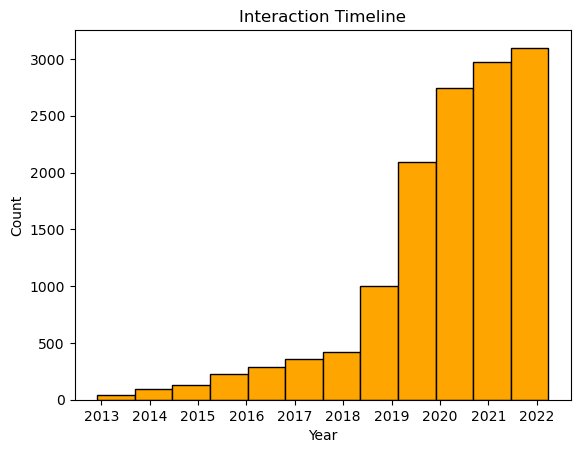

In [66]:
plt.hist(train_df['date'].astype('datetime64[ns]'), bins=12, color='orange', edgecolor='black')
plt.title("Interaction Timeline"); plt.xlabel("Year"); plt.ylabel("Count")
plt.show()

In [67]:
user_counts = train_df.groupby('uid').size().sort_values(ascending=False)
print("Top-10 most-active users:\n", user_counts.head(10))

Top-10 most-active users:
 uid
NqhTSgQq5RyzlrFA    23
OtyCrcFKUhiRCRdw    21
mElk8Wh1bcWXwlWo    17
GEiCLNtznzoMosD9    16
3Mdnpdne4njknJ62    16
k8MxgRYOLFmJKzP6    16
LIIhCYqcUSRe2AuH    16
N5xtJv0x8XfHFlIK    16
mk7aTgaLBekPAryt    15
gHWw3XaUav78ez3l    15
dtype: int64


## Collaborative Filtering Model

For this project, I used **RMSE (Root Mean Squared Error)** and **MAE (Mean Absolute Error)** to evaluate how well the model predicts user ratings.

- **MAE** is helpful because it tells me, on average, how far off the predictions are — it's easy to interpret and treats all errors equally.
- **RMSE**, on the other hand, gives more weight to larger errors. This is useful in a recommendation setting, where being slightly off is usually fine, but being way off stands out a lot more.

Since I'm trying to avoid those bigger misses, I used **RMSE as the main metric** to compare models during validation. It gave me a better sense of which models were not only consistent but also avoided those larger off-target predictions.


In [68]:
for df in (train_df, val_df):
    df["uid"] = df["uid"].astype(str)
    df["app_package"] = df["app_package"].astype(str)
    df["rating"] = df["rating"].astype(float)

reader = Reader(rating_scale=(train_df.rating.min(), train_df.rating.max()))
data_train = Dataset.load_from_df(train_df[["uid", "app_package", "rating"]], reader)
trainset = data_train.build_full_trainset()

sim_options = {"name": "cosine", "user_based": False}
bsl_options = {"method": "als", "n_epochs": 20, "reg_u": 0.02, "reg_i": 0.02}
models = {
    "BaselineOnly": BaselineOnly(bsl_options=bsl_options),
    "SVD": SVD(),
    "SVD++": SVDpp(),
    "NMF": NMF(),
    "KNNBaseline": KNNBaseline(sim_options=sim_options, bsl_options=bsl_options),
    "KNNWithZScore": KNNWithZScore(sim_options=sim_options),
    "NormalPredictor": NormalPredictor(),
}

results = []
for name, model in models.items():
    print(f"Training and validating: {name}")
    model.fit(trainset)

    val_preds = [model.predict(row.uid, row.app_package, r_ui=row.rating)
                 for _, row in val_df.iterrows()]
    rmse = accuracy.rmse(val_preds, verbose=False)
    mae = accuracy.mae(val_preds, verbose=False)

    results.append({
        "Model": name,
        "Val_RMSE": rmse,
        "Val_MAE": mae
    })

df_results = pd.DataFrame(results).sort_values("Val_RMSE").reset_index(drop=True)
best_model_name = df_results.loc[0, "Model"]

print("\nValidation Results (sorted by RMSE):")
print(df_results)
print(f"\nBest Model by RMSE on validation: {best_model_name}")


Training and validating: BaselineOnly
Estimating biases using als...
Training and validating: SVD
Training and validating: SVD++
Training and validating: NMF
Training and validating: KNNBaseline
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Training and validating: KNNWithZScore
Computing the cosine similarity matrix...
Done computing similarity matrix.
Training and validating: NormalPredictor

Validation Results (sorted by RMSE):
             Model  Val_RMSE   Val_MAE
0              SVD  1.600218  1.438048
1            SVD++  1.613026  1.443059
2    KNNWithZScore  1.765808  1.489195
3              NMF  1.915600  1.620716
4     BaselineOnly  1.930068  1.578721
5      KNNBaseline  1.930351  1.576092
6  NormalPredictor  2.029982  1.660263

Best Model by RMSE on validation: SVD


After identifying SVD and SVD++ as the top performers during model evaluation, I decided to focus my grid search on these two. The goal here was to fine-tune their hyperparameters and strike a good balance between underfitting and overfitting. I experimented with different combinations of latent factors, regularization strength, learning rate (for SVD), and the number of training epochs to see how they influenced performance. Each combination was evaluated using RMSE and MAE on the validation set, and the best-performing model was selected based on the lowest RMSE. This process helps ensure that the model not only fits the training data well but also generalizes better to unseen data.

That said, despite tuning, there's still some degree of overfitting. The validation RMSE hovers around 1.59, which is noticeably higher than the training RMSE (not shown here but observed during model fitting). This is likely due to the inherent sparsity of the data—many users have interacted with only a few apps—making it hard for the model to generalize well across such limited signals. In that context, even well-tuned models can struggle to predict ratings for unfamiliar users or niche items, which is a common challenge in real-world recommender systems.

In [69]:
def eval_model(model, trainset, val_df):
    model.fit(trainset)
    val_preds = [model.predict(row.uid, row.app_package, r_ui=row.rating) for _, row in val_df.iterrows()]
    rmse = accuracy.rmse(val_preds, verbose=False)
    mae = accuracy.mae(val_preds, verbose=False)
    return rmse, mae

reader = Reader(rating_scale=(train_df.rating.min(), train_df.rating.max()))
train_data = Dataset.load_from_df(train_df[["uid", "app_package", "rating"]], reader)
trainset = train_data.build_full_trainset()

grid_results = []
for n_factors, reg_all, lr_all, n_epochs in product(
    [20, 50, 100, 150],
    [0.01, 0.02, 0.05],
    [0.002, 0.005, 0.01],
    [10, 20]
):
    model = SVD(n_factors=n_factors, reg_all=reg_all, lr_all=lr_all, n_epochs=n_epochs, random_state=123)
    rmse, mae = eval_model(model, trainset, val_df)
    grid_results.append({
        "Model": "SVD",
        "Params": f"factors={n_factors}, reg={reg_all}, lr={lr_all}, epochs={n_epochs}",
        "Val_RMSE": rmse,
        "Val_MAE": mae,
        "ModelObj": model
    })

for n_factors, reg_all, n_epochs in product(
    [20, 50, 100, 150],
    [0.01, 0.02, 0.05],
    [10, 20]
):
    model = SVDpp(n_factors=n_factors, reg_all=reg_all, n_epochs=n_epochs, random_state=123)
    rmse, mae = eval_model(model, trainset, val_df)
    grid_results.append({
        "Model": "SVD++",
        "Params": f"factors={n_factors}, reg={reg_all}, epochs={n_epochs}",
        "Val_RMSE": rmse,
        "Val_MAE": mae,
        "ModelObj": model
    })

df_grid = pd.DataFrame(grid_results).sort_values("Val_RMSE").reset_index(drop=True)
best_row = df_grid.iloc[0]
best_model_tuned = best_row["ModelObj"]

print("\nTop Grid Search Results (sorted by RMSE):")
display(df_grid[["Model", "Params", "Val_RMSE", "Val_MAE"]].head(10))
print(f"\nBest Tuned Model: {best_row['Model']} with params: {best_row['Params']}")




Top Grid Search Results (sorted by RMSE):


,Model,Params,Val_RMSE,Val_MAE
0,SVD,"factors=50, reg=0.05, lr=0.002, epochs=10",1.588554,1.438198
1,SVD,"factors=50, reg=0.02, lr=0.002, epochs=10",1.588562,1.438192
2,SVD,"factors=50, reg=0.01, lr=0.002, epochs=10",1.588564,1.438190
3,SVD,"factors=50, reg=0.05, lr=0.002, epochs=20",1.588790,1.435984
4,SVD,"factors=50, reg=0.02, lr=0.002, epochs=20",1.588827,1.435990
5,SVD,"factors=50, reg=0.01, lr=0.002, epochs=20",1.588839,1.435992
6,SVD,"factors=20, reg=0.05, lr=0.002, epochs=20",1.589589,1.437202
7,SVD,"factors=20, reg=0.02, lr=0.002, epochs=20",1.589629,1.437219
8,SVD,"factors=20, reg=0.01, lr=0.002, epochs=20",1.589642,1.437225
9,SVD,"factors=20, reg=0.05, lr=0.002, epochs=10",1.589649,1.439960



Best Tuned Model: SVD with params: factors=50, reg=0.05, lr=0.002, epochs=10


## Content-Based Filtering Model

Clean and combine app name and description into a unified content_text column for content-based filtering.

In [70]:
def clean_text(text):
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def add_content_text_column(df):
    df["app_name_clean"] = df["app_name"].fillna("").apply(clean_text)
    df["description_clean"] = df["description"].fillna("").apply(clean_text)
    df["content_text"] = df["app_name_clean"] + " " + df["description_clean"]
    return df


train_df = add_content_text_column(train_df)


In [71]:
val_df = add_content_text_column(val_df)
test_df = add_content_text_column(test_df)

This block implements a content-based model using TF-IDF and K-Nearest Neighbors to recommend apps based on text similarity. I vectorized the cleaned app name and description, then used cosine distance to find the top k most similar apps. In the training loop, I used k+1 neighbors and excluded the app itself, since it’s always its own closest match. In the validation loop, I used exactly k because the app being evaluated is from the validation set and doesn’t exist in the training TF-IDF matrix — even if the same app appears in both sets for different users, it won’t be matched to itself. I tested a range of k values and chose k = 61 based on the point where validation RMSE flattened out in the graph. This choice strikes a good balance between overfitting and generalization by pulling from a large enough pool of neighbors without introducing too much noise.

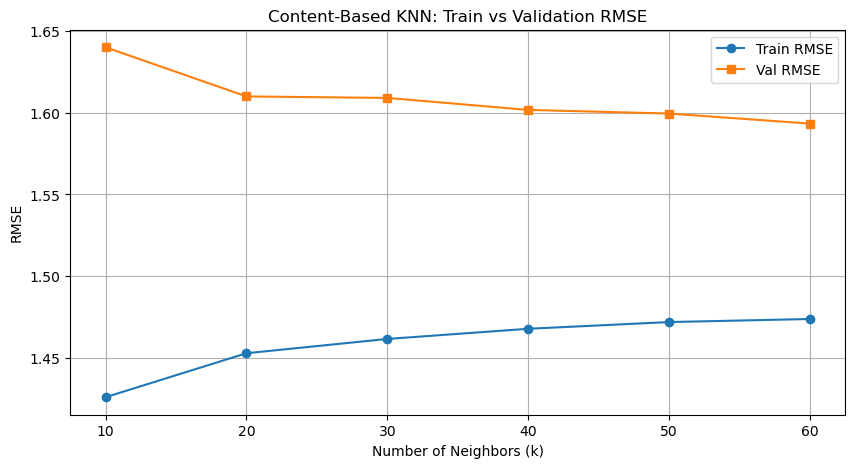

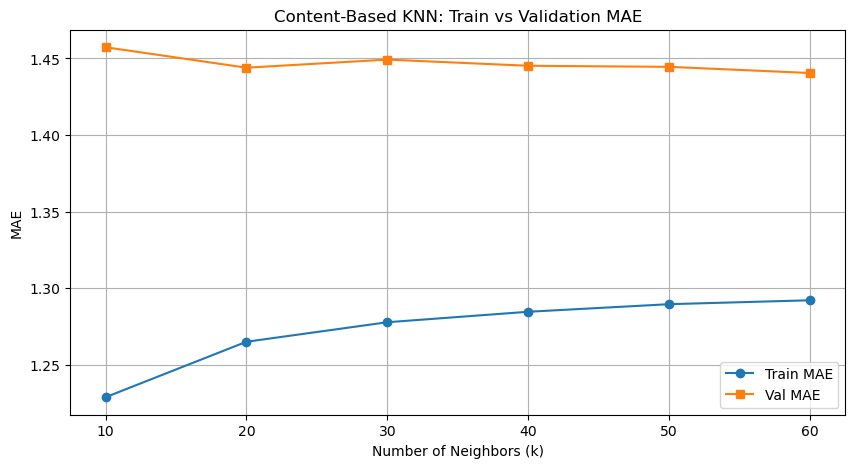


Top 5 Configurations (by Val_RMSE):
    k  Train_RMSE  Val_RMSE  Train_MAE   Val_MAE
5  60    1.473814  1.593285   1.292120  1.440467
4  50    1.471943  1.599441   1.289569  1.444493
3  40    1.467834  1.601666   1.284622  1.445192
2  30    1.461620  1.608999   1.277782  1.449222
1  20    1.452879  1.609911   1.265041  1.443933


In [72]:
tfidf = TfidfVectorizer(stop_words="english", max_features=10000)
tfidf_train = tfidf.fit_transform(train_df["content_text"])
tfidf_val = tfidf.transform(val_df["content_text"])

app_index_train = pd.Series(train_df.index, index=train_df["app_name"]).drop_duplicates()
results = []
ks = [10, 20, 30, 40, 50, 60]

for k in ks:
    nn_model = NearestNeighbors(metric="cosine", algorithm="auto", n_neighbors=k+1)
    nn_model.fit(tfidf_train)

    y_train_true, y_train_pred = [], []
    for i, row in train_df.iterrows():
        if row["app_name"] not in app_index_train:
            continue
        idx = app_index_train[row["app_name"]]
        tfidf_vec = tfidf_train[idx]
        distances, indices = nn_model.kneighbors(tfidf_vec, n_neighbors=k+1)
        top_indices = indices.flatten()[1:]
        neighbors = train_df.iloc[top_indices]
        if not neighbors.empty:
            y_train_true.append(row["rating"])
            y_train_pred.append(neighbors["rating"].mean())

    y_val_true, y_val_pred = [], []
    for i, row in val_df.iterrows():
        tfidf_vec = tfidf_val[i]
        distances, indices = nn_model.kneighbors(tfidf_vec, n_neighbors=k)
        neighbors = train_df.iloc[indices.flatten()]
        if not neighbors.empty:
            y_val_true.append(row["rating"])
            y_val_pred.append(neighbors["rating"].mean())

    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    val_rmse   = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
    train_mae  = mean_absolute_error(y_train_true, y_train_pred)
    val_mae    = mean_absolute_error(y_val_true, y_val_pred)

    results.append({
        "k": k,
        "Train_RMSE": train_rmse,
        "Val_RMSE": val_rmse,
        "Train_MAE": train_mae,
        "Val_MAE": val_mae
    })

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
plt.plot(df_results["k"], df_results["Train_RMSE"], label="Train RMSE", marker="o")
plt.plot(df_results["k"], df_results["Val_RMSE"], label="Val RMSE", marker="s")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.title("Content-Based KNN: Train vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_results["k"], df_results["Train_MAE"], label="Train MAE", marker="o")
plt.plot(df_results["k"], df_results["Val_MAE"], label="Val MAE", marker="s")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("MAE")
plt.title("Content-Based KNN: Train vs Validation MAE")
plt.legend()
plt.grid(True)
plt.show()

print("\nTop 5 Configurations (by Val_RMSE):")
print(df_results.sort_values("Val_RMSE").head(5))


## Hybrid Model

In [73]:
tfidf_test = tfidf.transform(test_df["content_text"])

In [74]:
nn_model = NearestNeighbors(metric="cosine", algorithm="auto")
nn_model.fit(tfidf_train)

app_index_train = pd.Series(train_df.index, index=train_df["app_name"]).drop_duplicates()
def get_content_based_pred(app_name):
    if app_name not in app_index_train:
        return np.nan
    idx = app_index_train[app_name]
    tfidf_vec = tfidf_train[idx]
    distances, indices = nn_model.kneighbors(tfidf_vec, n_neighbors=61)
    neighbor_ratings = train_df.iloc[indices.flatten()[1:]]["rating"]
    return neighbor_ratings.mean() if not neighbor_ratings.empty else np.nan

def get_collab_pred(uid, app_package):
    return best_model_tuned.predict(uid, app_package).est
weights = np.arange(0.0, 1.1, 0.1)
val_results = []

for w in weights:
    hybrid_preds = []
    actual_ratings = []

    for _, row in val_df.iterrows():
        r_cb = get_content_based_pred(row["app_name"])
        r_cf = get_collab_pred(row["uid"], row["app_package"])

        if np.isnan(r_cb):
            hybrid = r_cf
        else:
            hybrid = w * r_cb + (1 - w) * r_cf

        hybrid_preds.append(hybrid)
        actual_ratings.append(row["rating"])

    rmse = np.sqrt(mean_squared_error(actual_ratings, hybrid_preds))
    mae = mean_absolute_error(actual_ratings, hybrid_preds)
    val_results.append({"weight_cb": w, "Val_RMSE": rmse, "Val_MAE": mae})

df_hybrid_val = pd.DataFrame(val_results).sort_values("Val_RMSE").reset_index(drop=True)
best_weight = df_hybrid_val.iloc[0]["weight_cb"]

# print(f"\nBest Weight (content-based): {best_weight:.2f}")
# print(df_hybrid_val.head())

# # --- Step 2: Evaluate on test_df using best weight ---
# test_preds = []
# test_truth = []

# for _, row in test_df.iterrows():
#     r_cb = get_content_based_pred(row["app_name"])
#     r_cf = get_collab_pred(row["uid"], row["app_package"])

#     if np.isnan(r_cb):
#         hybrid = r_cf
#     else:
#         hybrid = best_weight * r_cb + (1 - best_weight) * r_cf

#     test_preds.append(hybrid)
#     test_truth.append(row["rating"])

# rmse_test = np.sqrt(mean_squared_error(test_truth, test_preds))
# mae_test = mean_absolute_error(test_truth, test_preds)

# print(f"\nHybrid Test RMSE: {rmse_test:.4f}")
# print(f"Hybrid Test MAE:  {mae_test:.4f}")


## Save Model Dependencies

In [75]:
save_dir = "models"
print(f"Saving all models to: {save_dir}")

with open(f"{save_dir}/best_model_tuned.pkl", "wb") as f:
    pickle.dump(best_model_tuned, f)

with open(f"{save_dir}/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

joblib.dump(tfidf_train, f"{save_dir}/tfidf_train_matrix.pkl")

with open(f"{save_dir}/nn_model.pkl", "wb") as f:
    pickle.dump(nn_model, f)

with open(f"{save_dir}/app_index_train.pkl", "wb") as f:
    pickle.dump(app_index_train, f)

with open(f"{save_dir}/best_weight.txt", "w") as f:
    f.write(str(best_weight))


Saving all models to: models


## Loading Them Back

In [76]:
load_dir = "models"
print(f"Loading all models from: {load_dir}")

with open(f"{load_dir}/best_model_tuned.pkl", "rb") as f:
    best_model_tuned = pickle.load(f)

with open(f"{load_dir}/tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

tfidf_train = joblib.load(f"{load_dir}/tfidf_train_matrix.pkl")

with open(f"{load_dir}/nn_model.pkl", "rb") as f:
    nn_model = pickle.load(f)

with open(f"{load_dir}/app_index_train.pkl", "rb") as f:
    app_index_train = pickle.load(f)

with open(f"{load_dir}/best_weight.txt", "r") as f:
    best_weight = float(f.read())




Loading all models from: models


In [77]:
best_weight

0.2

In [78]:
def get_content_based_pred(app_name):
    if app_name not in app_index_train:
        return np.nan
    idx = app_index_train[app_name]
    tfidf_vec = tfidf_train[idx]
    distances, indices = nn_model.kneighbors(tfidf_vec, n_neighbors=61)
    neighbor_ratings = train_df.iloc[indices.flatten()[1:]]["rating"]
    return neighbor_ratings.mean() if not neighbor_ratings.empty else np.nan

def get_collab_pred(uid, app_package):
    return best_model_tuned.predict(uid, app_package).est

In [79]:
test_preds = []
test_truth = []

for _, row in test_df.iterrows():
    r_cb = get_content_based_pred(row["app_name"])
    r_cf = get_collab_pred(row["uid"], row["app_package"])

    if np.isnan(r_cb):
        hybrid = r_cf
    else:
        hybrid = best_weight * r_cb + (1 - best_weight) * r_cf

    test_preds.append(hybrid)
    test_truth.append(row["rating"])

rmse_test = np.sqrt(mean_squared_error(test_truth, test_preds))
mae_test = mean_absolute_error(test_truth, test_preds)

print(f"\nHybrid Test RMSE: {rmse_test:.4f}")
print(f"Hybrid Test MAE:  {mae_test:.4f}")


Hybrid Test RMSE: 1.6508
Hybrid Test MAE:  1.5188


In [80]:
print(f"Min prediction: {min(test_preds):.2f}")
print(f"Max prediction: {max(test_preds):.2f}")

Min prediction: 2.86
Max prediction: 3.55


I combined the predictions from my best collaborative filtering and content-based models using a weighted average, where the content-based weight (0.2) was selected based on validation performance. Since both components had already been tuned using the train and val sets, and the hybrid weight was also chosen based on validation results, I didn’t need to re-evaluate everything separately on the test set. Instead, I focused on assessing the final hybrid model as a whole. It achieved a test RMSE of 1.6508 and MAE of 1.5188. The predicted ratings stayed within a tight range—from 2.86 to 3.55—which suggests the model tends to play it safe rather than making bold guesses. That kind of behavior makes sense given the sparse and noisy nature of user feedback in the dataset, and it likely helped keep the RMSE relatively low.

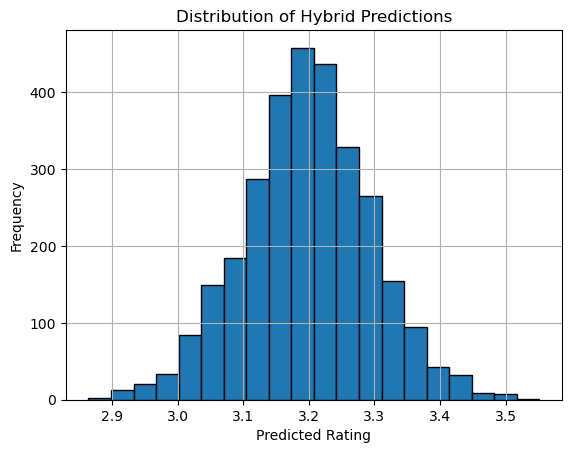

In [81]:
plt.hist(test_preds, bins=20, edgecolor='k')
plt.title("Distribution of Hybrid Predictions")
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Prediction Error vs. User Data Availability
Users with fewer training interactions generally have more scattered and higher prediction errors, which makes sense given how little the model has to learn from in those cases.

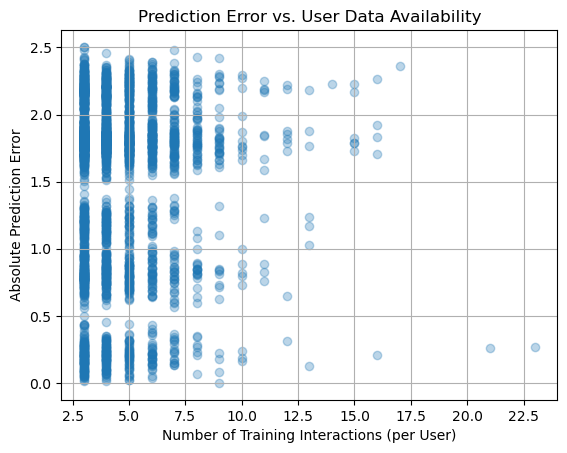

In [82]:
user_train_counts = train_df["uid"].value_counts()
test_df["train_interactions"] = test_df["uid"].map(user_train_counts)

test_df["abs_error"] = np.abs(np.array(test_df["rating"]) - np.array(test_preds))

plt.scatter(test_df["train_interactions"], test_df["abs_error"], alpha=0.3)
plt.xlabel("Number of Training Interactions (per User)")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error vs. User Data Availability")
plt.grid(True)
plt.show()



## Distribution of Prediction Errors
Most errors are centered around ±2, which means the model often predicts closer to the middle of the scale even when the actual rating is at one of the extremes. This highlights a tendency to avoid confident predictions.

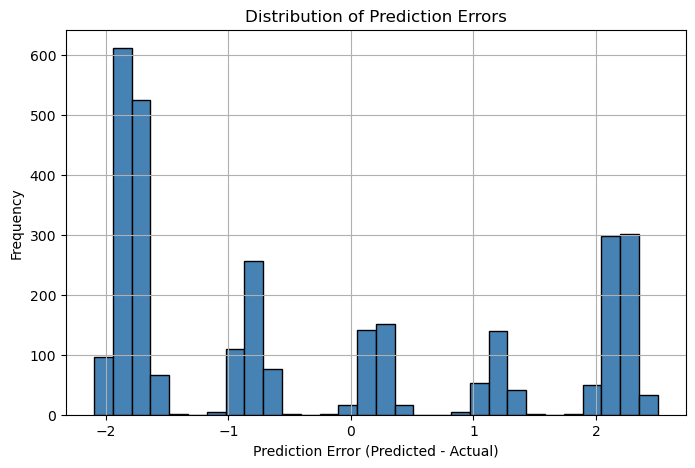

In [85]:
errors = np.array(test_preds) - np.array(test_truth)

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Prediction Error by Actual Rating
The model tends to overestimate low ratings and underestimate high ones, which shows it’s playing it safe and pulling predictions toward the middle.

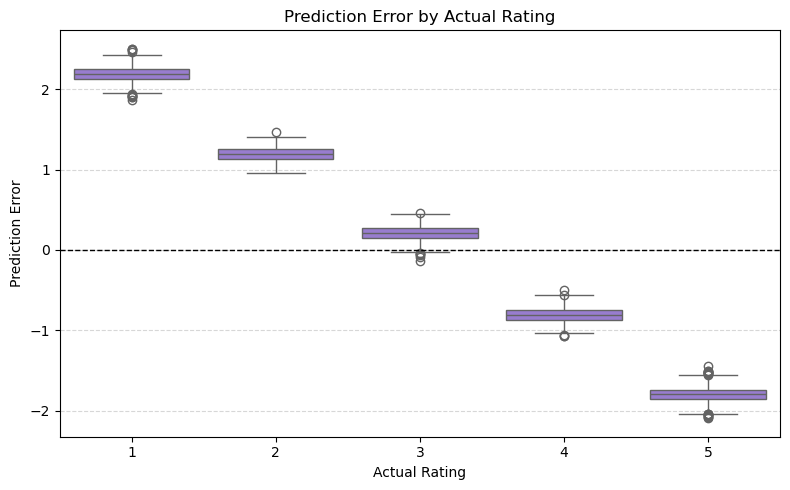

In [86]:
result_df_3 = pd.DataFrame({
    "actual": test_truth,
    "predicted": test_preds
})
result_df_3["error"] = result_df_3["predicted"] - result_df_3["actual"]

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x="actual", y="error", data=result_df_3, color="mediumpurple")
plt.title("Prediction Error by Actual Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Prediction Error")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # reference line
plt.tight_layout()
plt.show()

In [87]:
def recommend_apps_for_user(uid, n=3):
    # Step 1: Show user history
    user_history = df_merged[df_merged["uid"] == uid].sort_values("date")
    print(f"User {uid} Rating History ({len(user_history)} apps):")
    display(user_history[["app_name", "rating", "app_category", "date"]])

    # Step 2: Build recommendation list
    all_apps = train_df["app_package"].unique()
    recs = []

    for app in all_apps:
        app_row = train_df[train_df["app_package"] == app].iloc[0]
        app_name = app_row["app_name"]
        r_cb = get_content_based_pred(app_name)
        r_cf = get_collab_pred(uid, app)

        if np.isnan(r_cb):
            pred = r_cf
        else:
            pred = best_weight * r_cb + (1 - best_weight) * r_cf

        recs.append({
            "app_package": app,
            "app_name": app_name,
            "predicted_rating": pred,
            "r_cb": r_cb,
            "r_cf": r_cf,
            "app_category": app_row["app_category"],
            "developer": app_row["developer_name"]
        })

    recs_df = pd.DataFrame(recs)

    # Optional: Remove already rated apps
    rated_apps = set(user_history["app_package"])
    recs_df = recs_df[~recs_df["app_package"].isin(rated_apps)]

    # Step 3: Display top-N recommendations
    top_recs = recs_df.sort_values("predicted_rating", ascending=False).head(n).reset_index(drop=True)
    print(f"\nTop {n} Recommendations for User {uid}:")
    return top_recs

In [88]:
# Get predictions into test_df
test_df["predicted_rating"] = test_preds
test_df["abs_error"] = np.abs(test_df["rating"] - test_df["predicted_rating"])

# Sort test_df by lowest absolute error (i.e., model got it right)
top_matches = test_df.sort_values("abs_error").head(20)

# Pick the first user
example_uid = top_matches["uid"].iloc[0]

# View that user’s history and recommendations
recommend_apps_for_user(example_uid, n=5)


User aMIIlFT1h0bPfUMr Rating History (11 apps):


,app_name,rating,app_category,date
11210,Age of Ishtaria - A.Battle RPG,5,Card,2019-04-26
11211,Overdrive - Ninja Shadow Revenge,3,Action,2020-08-06
11212,Boom Slingers,1,Action,2021-04-02
11213,Magic Jigsaw Puzzles - Game HD,3,Puzzle,2021-04-25
11214,DICE: Events & Streams,1,Music & Audio,2021-07-22
11215,Baby Games for 1+ Toddlers,4,Educational,2021-12-28
11216,Superb Casino - HD Slots Games,5,Casino,2022-01-13
11217,Empires & Puzzles: Match-3 RPG,1,Puzzle,2022-02-17
11218,Rock N' Cash Vegas Slot Casino,4,Casino,2022-02-25
11219,PixelLab - Text on pictures,5,Photography,2022-03-14



Top 5 Recommendations for User aMIIlFT1h0bPfUMr:


,app_package,app_name,predicted_rating,r_cb,r_cf,app_category,developer
0,com.mg.smplan,To Do List with Reminder,3.533174,3.617284,3.512146,Productivity,tact
1,com.addictive.strategy.tower,Tower Clash,3.522928,3.815789,3.449713,Strategy,Fastone Games HK
2,com.TibetanLiss.pd3,Protect & Defense: Tower Zone,3.505007,3.835391,3.422411,Strategy,Tibetan Liss
3,com.hound13.hundredsoulglobal,Hundred Soul : The Last Savior,3.501912,3.556650,3.488227,Action,HOUND 13
4,com.fivebn.tl2.f2p,The Legacy 2,3.476710,3.945055,3.359623,Adventure,FIVE-BN GAMES


## Future Improvements
While the model performs well, there are several ways I could extend and improve this work:

- **Data**: I could scale up to a larger sample size to validate model performance across broader user populations, having started with a smaller subset for faster prototyping already.
- **Features**: I could introduce additional app-level features, such as install counts, update frequency, and review sentiment scores, to enrich app profiles beyond the existing metadata.
- **Model**: I could explore neural network-based recommenders to better capture nonlinear patterns and personalize recommendations more effectively.
- **Evaluation**: I could address the conservatively predicted rating range, currently between 2.69 and 3.52, by tuning loss functions and improving model calibration.

With these improvements, the system could become more robust and effective at scale.